In [21]:
from cassandra.cluster import Cluster, ExecutionProfile, EXEC_PROFILE_DEFAULT
from cassandra import ConsistencyLevel
from cassandra_sigv4.auth import SigV4AuthProvider
from ssl import SSLContext, PROTOCOL_TLSv1_2, CERT_REQUIRED
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv


# -----------------------------
# SETUP CONNECTION
# -----------------------------
ssl_context = SSLContext(PROTOCOL_TLSv1_2)
ssl_context.load_verify_locations("sf-class2-root.crt")
ssl_context.verify_mode = CERT_REQUIRED

boto_session = boto3.Session(region_name="us-east-2")
auth_provider = SigV4AuthProvider(boto_session)

execution_profile = ExecutionProfile(
    consistency_level=ConsistencyLevel.LOCAL_QUORUM
)

cluster = Cluster(
    ['cassandra.us-east-2.amazonaws.com'],
    port=9142,
    ssl_context=ssl_context,
    auth_provider=auth_provider,
    execution_profiles={EXEC_PROFILE_DEFAULT: execution_profile}
)

session = cluster.connect()

session.execute("""
    CREATE KEYSPACE IF NOT EXISTS ueb9720_hw2
    WITH replication = {
        'class': 'SimpleStrategy',
        'replication_factor': 3
    }
""")
session.set_keyspace('ueb9720_hw2')  # replace with your keyspace name if different


# -----------------------------
# LIST ALL TABLES IN THE KEYSPACE
# -----------------------------
print("📋 Tables in keyspace 'ueb9720_hw2':\n")
tables = session.execute("""
    SELECT table_name FROM system_schema.tables WHERE keyspace_name = 'ueb9720_hw2';
""")
for row in tables:
    print("-", row.table_name)


# -----------------------------
# CLEANUP
# -----------------------------
#session.shutdown()  # Uncomment if you want to close connection at the end

/tmp/ipykernel_2548/3010244054.py:15: DeprecationWarning: ssl.PROTOCOL_TLSv1_2 is deprecated
  ssl_context = SSLContext(PROTOCOL_TLSv1_2)


📋 Tables in keyspace 'ueb9720_hw2':

- icu_stays_ueb9720
- prescriptions_by_ethnicity_ueb9720
- procedures_by_age_ueb9720


In [22]:
#Analysis Question 1

In [23]:
session.execute("""
    CREATE TABLE IF NOT EXISTS prescriptions_by_ethnicity_ueb9720 (
        ethnicity text,
        subject_id int,
        hadm_id int,
        drug text,
        form_unit_disp text,
        drug_type text,
        PRIMARY KEY ((ethnicity), subject_id, hadm_id, drug, form_unit_disp)
    )
""")

In [24]:

with open('drug_type_ethnicity_partII_ueb9720.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for i, row in enumerate(reader):
        try:
            session.execute("""
                INSERT INTO prescriptions_by_ethnicity_ueb9720 (
                    ethnicity, subject_id, hadm_id, drug, form_unit_disp, drug_type
                ) VALUES (%s, %s, %s, %s, %s, %s)
            """, (
                row['ethnicity'],
                int(row['subject_id']),
                int(row['hadm_id']),
                row['drug'],
                row['form_unit_disp'],
                row['drug_type']
            ))
        except Exception as e:
            print(f"[Row {i}] Skipped due to error: {e}")

In [25]:
rows = session.execute("""
    SELECT ethnicity, drug_type
    FROM prescriptions_by_ethnicity_ueb9720
""")
records = [{"ethnicity": r.ethnicity, "drug_type": r.drug_type} for r in rows]
df = pd.DataFrame(records)

In [26]:
excluded = ['OTHER', 'UNKNOWN/NOT SPECIFIED', 'UNABLE TO OBTAIN']
df = df[~df['ethnicity'].isin(excluded)]
grouped = df.groupby(['ethnicity', 'drug_type']).size().reset_index(name='prescription_count')

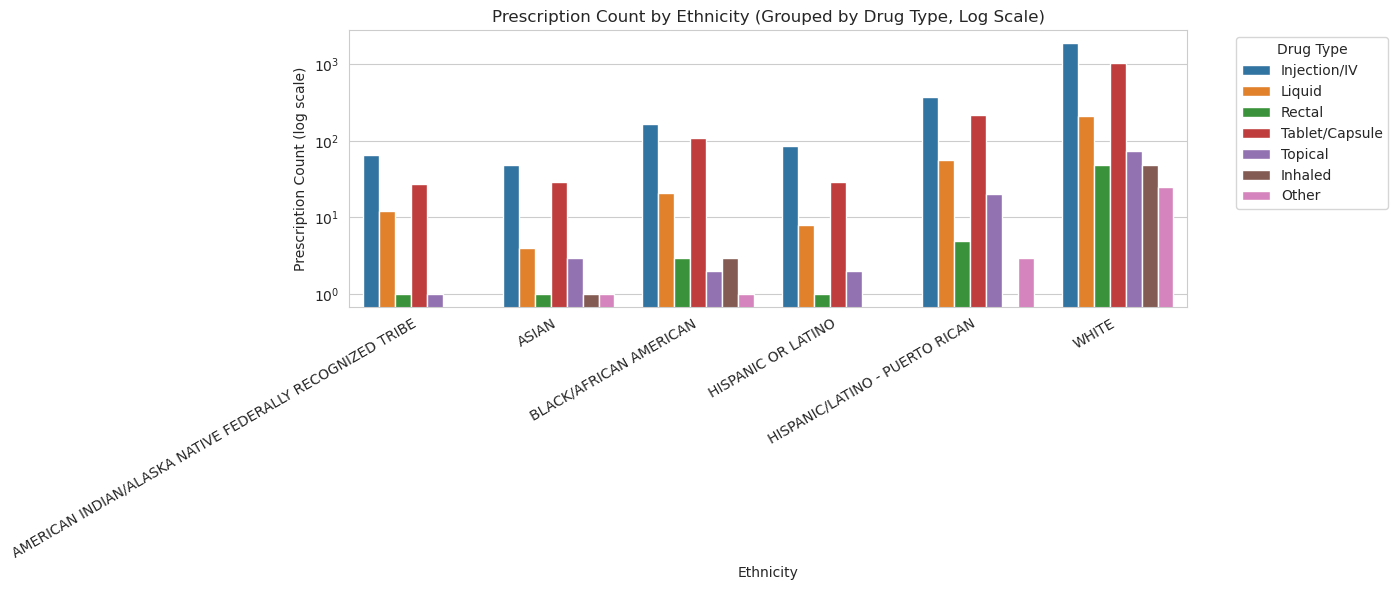

In [27]:
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

sns.barplot(
    data=grouped,
    x="ethnicity",
    y="prescription_count",
    hue="drug_type"
)

plt.yscale('log')  # This is the correct way to apply log scale
plt.title("Prescription Count by Ethnicity (Grouped by Drug Type, Log Scale)")
plt.xlabel("Ethnicity")
plt.ylabel("Prescription Count (log scale)")
plt.xticks(rotation=30, ha='right')
plt.legend(title="Drug Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [28]:
#Analysis Question 2

In [29]:
session.execute("""
    CREATE TABLE IF NOT EXISTS procedures_by_age_ueb9720 (
        subject_id int,
        hadm_id int,
        icd9_code text,
        procedure_title text,
        age_at_admit int,
        age_group text,
        seq_num int,
        PRIMARY KEY ((age_group), subject_id, hadm_id, icd9_code,seq_num)
    )
""")

In [30]:
with open('admissions_with_age_partII_ueb9720.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for i, row in enumerate(reader):
        try:
            session.execute("""
                INSERT INTO procedures_by_age_ueb9720 (
                    age_group, subject_id, hadm_id, icd9_code, procedure_title, age_at_admit, seq_num
                ) VALUES (%s, %s, %s, %s, %s, %s, %s)
            """, (
                row["age_group"],
                int(row["subject_id"]),
                int(row["hadm_id"]),
                row["icd9_code"],
                row["procedure_title"],
                int(float(row["age_at_admit"])),
                int(row['seq_num'])
            ))
        except Exception as e:
            print(f"Row {i} skipped due to error: {e}")

In [31]:
rows = session.execute("SELECT age_group, procedure_title FROM procedures_by_age_ueb9720")
df = pd.DataFrame(rows)
procedures = (
    df.groupby(["age_group", "procedure_title"])
    .size()
    .reset_index(name="count")
    .sort_values(["age_group", "count"], ascending=[True, False])
)
procedures["rank"] = procedures.groupby("age_group")["count"].rank(method="dense", ascending=False)
top_3 = procedures[procedures["rank"] <= 3].reset_index(drop=True)

In [32]:
top_3

,age_group,procedure_title,count,rank
0,0-19,"Venous catheterization, not elsewhere classified",3,1.0
1,0-19,Closure of skin and subcutaneous tissue of oth...,2,2.0
2,0-19,"Application of external fixator device, femur",1,3.0
3,0-19,Arterial catheterization,1,3.0
4,0-19,Atlas-axis spinal fusion,1,3.0
5,0-19,Closed [endoscopic] biopsy of bronchus,1,3.0
6,0-19,Closed reduction of fracture without internal ...,1,3.0
7,0-19,Enteral infusion of concentrated nutritional s...,1,3.0
8,0-19,Fusion or refusion of 2-3 vertebrae,1,3.0
9,0-19,Interruption of the vena cava,1,3.0


In [33]:
#Analysis Question 3

In [34]:
session.execute("""
CREATE TABLE IF NOT EXISTS icu_stays_ueb9720 (
    icustay_id INT PRIMARY KEY,
    subject_id INT,
    hadm_id INT,
    gender TEXT,
    ethnicity TEXT,
    icu_stay_hours DOUBLE,
    log_icu_stay_hours DOUBLE
);""")

In [35]:
with open("patient_ICU_duration_partII_ueb9720.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        session.execute("""
            INSERT INTO icu_stays_ueb9720 (
                icustay_id, subject_id, hadm_id,
                gender, ethnicity,
                icu_stay_hours, log_icu_stay_hours
            ) VALUES (%s, %s, %s, %s, %s, %s, %s)
        """, (
            int(row["icustay_id"]),
            int(row["subject_id"]),
            int(row["hadm_id"]),
            row["gender"],
            row["ethnicity"],
            float(row["icu_stay_hours"]),
            float(row["log_icu_stay_hours"])
        ))

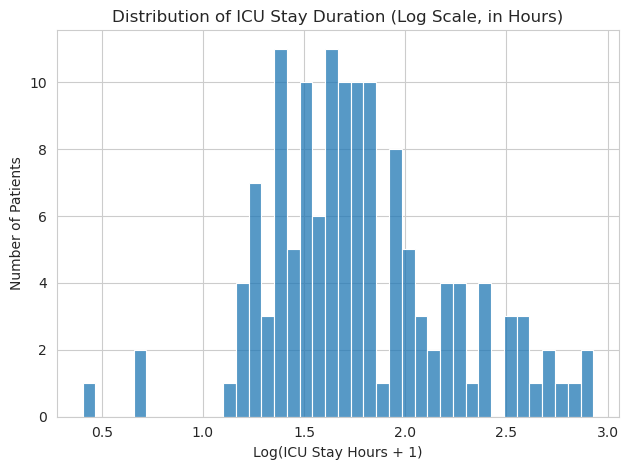

In [36]:
rows = session.execute("SELECT log_icu_stay_hours FROM icu_stays_ueb9720")
icu_duration_df = pd.DataFrame(rows)
sns.histplot(data=icu_duration_df, x="log_icu_stay_hours", bins=40)
plt.title("Distribution of ICU Stay Duration (Log Scale, in Hours)")
plt.xlabel("Log(ICU Stay Hours + 1)")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.show()

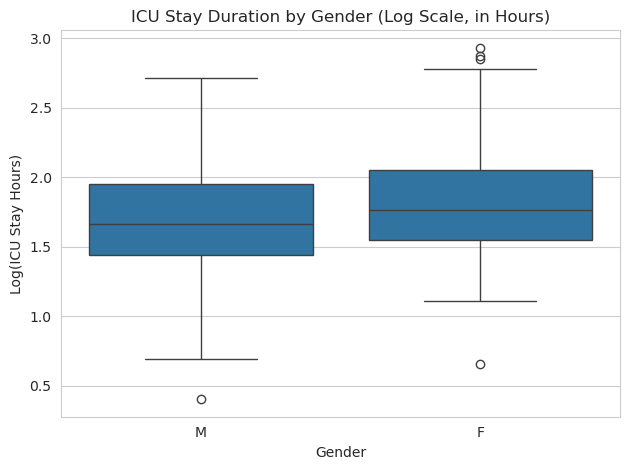

In [37]:
rows = session.execute("SELECT log_icu_stay_hours, gender FROM icu_stays_ueb9720")
icu_duration_df = pd.DataFrame(rows)

sns.boxplot(data=icu_duration_df, x="gender", y="log_icu_stay_hours")
plt.title("ICU Stay Duration by Gender (Log Scale, in Hours)")
plt.xlabel("Gender")
plt.ylabel("Log(ICU Stay Hours)")
plt.tight_layout()
plt.show()

/tmp/ipykernel_2548/3871172649.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icu_duration_filtered_df["ethnicity"] = icu_duration_filtered_df["ethnicity"].replace(


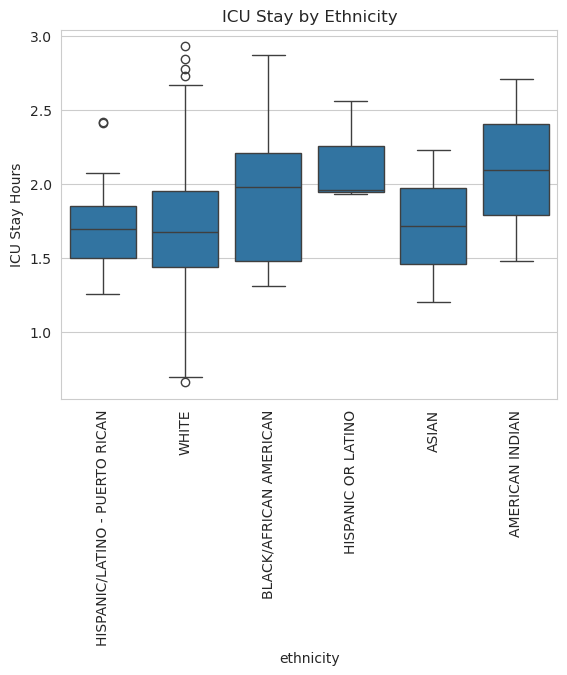

In [38]:
rows = session.execute("SELECT log_icu_stay_hours, ethnicity FROM icu_stays_ueb9720")
icu_duration_df = pd.DataFrame(rows)

icu_duration_filtered_df = icu_duration_df[~icu_duration_df["ethnicity"].isin([
    "OTHER", "UNABLE TO OBTAIN", "UNKNOWN/NOT SPECIFIED"
])]

# Rename long label
icu_duration_filtered_df["ethnicity"] = icu_duration_filtered_df["ethnicity"].replace(
    {"AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE": "AMERICAN INDIAN"}
)

sns.boxplot(data=icu_duration_filtered_df, x="ethnicity", y="log_icu_stay_hours")
plt.xticks(rotation=90)
plt.ylabel("ICU Stay Hours")
plt.title("ICU Stay by Ethnicity")
plt.show()